## 主題 : 台灣債券



憲聰整理的工具
- 情緒分析任務 : ckip, snnownlp, spacy
- 關聯、分群任務 : bigram、TFIDF、embedding
- 主題模型任務 : LDA
- transformer、bertopic : 情緒分析、NER任務...  

資料來源
- ptt股票版、期權版、金融版與外匯版，關鍵字有台灣債券、ETF、債券
- 時間為2023/05/10-2024/05/10
- 2699筆

In [66]:
import pandas as pd
import re
import jieba
from wordcloud import WordCloud 
from matplotlib import font_manager
import matplotlib.pyplot as plt
import pprint

主題模型

In [62]:
from gensim.corpora import Dictionary
from gensim.models import LdaModel, CoherenceModel
from gensim.models.ldamulticore import LdaMulticore
from gensim.matutils import corpus2csc, corpus2dense, Sparse2Corpus

In [27]:
# Path to the custom font
font_path = '../font/TraditionalChinese.ttf'

# Add the custom font to the font manager
font_manager.fontManager.addfont(font_path)

# After adding the font, search for it by filename to get the correct font name
for font in font_manager.fontManager.ttflist:
    if font.fname == font_path:
        print(f"Found font: {font.name}")
        plt.rcParams['font.family'] = font.name
        break

Found font: Noto Sans TC


In [6]:
raw_data=pd.read_csv('債券_ptt.csv')

In [41]:
raw_data

,system_id,artUrl,artTitle,artDate,artPoster,artCatagory,artContent,artComment,e_ip,insertedDate,dataSource
0,1,https://www.ptt.cc/bbs/Finance/M.1684317581.A....,[新聞]TDR未經主管機關核定金管會陷人民於罪,2023-05-17 17:59:39,marmar,Finance,TDR未經主管機關核定 金管會陷人民於罪恐觸「偽造文書」\nhttps://bit.ly/3...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""superficial""...",101.9.193.191,2023-05-18 01:10:59,ptt
1,2,https://www.ptt.cc/bbs/Finance/M.1685429102.A....,[新聞]SWAP大爆發彰銀今年有看頭,2023-05-30 14:45:00,jasonng,Finance,彰化銀行受惠台美利差擴大，SWAP（換匯交易）獲利大爆發。彰銀總經理周朝崇29日在法說會中指...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""hot8899"", ""c...",111.248.148.96,2023-05-31 01:12:07,ptt
2,3,https://www.ptt.cc/bbs/Finance/M.1685616807.A....,[新聞]永豐銀董座曹為實專訪／永豐銀做強做大,2023-06-01 18:53:25,pinpin0702,Finance,新聞標題：永豐銀董座曹為實專訪／永豐銀做強做大 三面向進擊\n新聞網址：\nhttps://...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""nxuanr"", ""cm...",42.79.130.108,2023-06-02 01:11:48,ptt
3,4,https://www.ptt.cc/bbs/Finance/M.1687613871.A....,[請益]銀行往來資產的保險是怎麼計算的？,2023-06-24 21:37:49,tpcjotp,Finance,台新富裕會員：所有與本行往來之資產總額(包含臺外幣存款、基金、結構型商品、信託、\n保險費之...,"[{""cmtStatus"": ""→"", ""cmtPoster"": ""SexyBack"", ""...",101.137.233.85,2023-06-25 01:12:27,ptt
4,5,https://www.ptt.cc/bbs/Finance/M.1692747049.A....,[新聞]金管會曾示警壽險業閃過三大雷區,2023-08-23 07:30:47,kim,Finance,新聞來源：聯合新聞網\nhttps://udn.com/news/amp/story/723...,"[{""cmtStatus"": ""噓"", ""cmtPoster"": ""MyConley"", ""...",114.136.149.170,2023-09-09 01:14:20,ptt
...,...,...,...,...,...,...,...,...,...,...,...
2694,2695,https://www.ptt.cc/bbs/Stock/M.1715298775.A.04...,[新聞]萬海Q1轉盈！航運多頭報到陽明、長榮,2024-05-10 07:52:53,IzumiKonata,Stock,原文標題：\n萬海Q1轉盈！航運多頭報到 陽明、長榮獲利備受期待\n\n原文連結：\nhtt...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""blackbrid"", ...",49.216.43.188,2024-05-12 02:11:22,ptt
2695,2696,https://www.ptt.cc/bbs/Stock/M.1715303490.A.A1...,Re:[標的]2618長榮航,2024-05-10 09:11:28,mythtaker,Stock,"合\nHi, 我凹單王\n跌一下就一堆信，一堆想酸的…\n昨天有打停利點，但盤中覺得殺的過頭...","[{""cmtStatus"": ""推"", ""cmtPoster"": ""joe61715"", ""...",42.72.67.98,2024-05-12 02:11:22,ptt
2696,2697,https://www.ptt.cc/bbs/Stock/M.1715320098.A.1C...,[新聞]軍工產業夯什麼？這「3大優勢」難以取代,2024-05-10 13:48:15,P1k4,Stock,主文連結：\nhttps://www.businesstoday.com.tw/articl...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""cuteSquirrel...",1.173.188.135,2024-05-12 02:11:27,ptt
2697,2698,https://www.ptt.cc/bbs/Stock/M.1715331818.A.7C...,[請益]買ETF會避開手上持股嗎?,2024-05-10 17:03:36,GoodGoodBoy,Stock,最近操作真的很不順，都懷疑我是不是反指標\n跟同事一起買了長榮、矽統、緯創、華泰都套在高點\...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""iversonya"", ...",114.140.81.123,2024-05-12 02:11:39,ptt


前處理

In [58]:
MetaData = raw_data.copy()

#去除文章內容為空值的筆數
MetaData.dropna(subset = ['artContent'], axis=0, how='any', inplace=True)

# 去除一些不需要的欄位
MetaData = MetaData.drop(['artPoster', 'artCatagory', 'artComment', 'e_ip', 'insertedDate', 'dataSource'], axis=1)
# 只留下中文字
MetaData['artContent']=MetaData['artContent']
MetaData['artContent'] = MetaData['artContent'].apply(lambda x: re.sub('[^\u4e00-\u9fff]+', '',x))

#新增['sentence']欄位，用'。'取代'\n\n'，並移除'\n'
MetaData['artContent'] = MetaData['artContent'].str.replace(r'\n\n','。', regex=True)
MetaData['artContent'] = MetaData['artContent'].str.replace(r'\n','', regex=True)
MetaData['artContent'] = MetaData['artContent'].str.lower()

#移除內文中的網址
MetaData['artContent'] = MetaData['artContent'].replace(r'http\S+', '', regex=True).replace(r'www\S+', '', regex=True)

# 對日期處理(拿掉時間)

MetaData['artDate'] = pd.to_datetime(MetaData['artDate'])
MetaData['artDate'] = MetaData['artDate'].dt.date
MetaData.head()

,system_id,artUrl,artTitle,artDate,artContent
0,1,https://www.ptt.cc/bbs/Finance/M.1684317581.A....,[新聞]TDR未經主管機關核定金管會陷人民於罪,2023-05-17,未經主管機關核定金管會陷人民於罪恐觸偽造文書因證券交易法未將臺灣存託憑證明文入法主管機關亦未...
1,2,https://www.ptt.cc/bbs/Finance/M.1685429102.A....,[新聞]SWAP大爆發彰銀今年有看頭,2023-05-30,彰化銀行受惠台美利差擴大換匯交易獲利大爆發彰銀總經理周朝崇日在法說會中指出第一季收益逾億元年...
2,3,https://www.ptt.cc/bbs/Finance/M.1685616807.A....,[新聞]永豐銀董座曹為實專訪／永豐銀做強做大,2023-06-01,新聞標題永豐銀董座曹為實專訪永豐銀做強做大三面向進擊新聞網址經濟日報記者楊筱筠台北報導永豐銀...
3,4,https://www.ptt.cc/bbs/Finance/M.1687613871.A....,[請益]銀行往來資產的保險是怎麼計算的？,2023-06-24,台新富裕會員所有與本行往來之資產總額包含臺外幣存款基金結構型商品信託保險費之總金額不包含與往...
4,5,https://www.ptt.cc/bbs/Finance/M.1692747049.A....,[新聞]金管會曾示警壽險業閃過三大雷區,2023-08-23,新聞來源聯合新聞網金管會曾示警壽險業閃過三大雷區經濟日報記者廖珮君楊筱筠台北報導保險局副局長...


In [ ]:
# 斷句
sentnece_df=MetaData.copy()
sentnece_df['sentence'] = sentnece_df['artContent'].str.replace(r'\n\n','。', regex=True)
sentnece_df['sentence'] = sentnece_df['sentence'].str.replace(r'\n','', regex=True)
sentnece_df['sentence'] = sentnece_df['sentence'].str.split("[,，。！!？?]{1,}")

sentnece_df = sentnece_df.explode('sentence').reset_index(drop=True)

#去除句子中除了字母、數字、空白字符以外的符號
sentnece_df['sentence'] = sentnece_df['sentence'].str.replace(r'[^\w\s]+', '', regex=True).astype(str)
sentnece_df['sentence'] = sentnece_df['sentence'].str.replace(r'\d+', '', regex=True).astype(str)

# 把長度小於1的sentence刪掉
sentnece_df = sentnece_df[sentnece_df["sentence"].str.len() > 1]

# 統一把英文變小寫
sentnece_df['sentence'] = sentnece_df['sentence'].str.lower()

sentnece_df.head(3)

In [97]:
# 設定繁體中文詞庫
jieba.set_dictionary('./dict/dict.txt.big')
jieba.load_userdict('dict/user_dict.txt')
# 新增stopwords
with open('./dict/stop_words.txt',encoding="utf-8") as f:
    stopWords = [line.strip() for line in f.readlines()]


Building prefix dict from /Users/tsaipingyu/Library/CloudStorage/GoogleDrive-jerryone888@gmail.com/其他電腦/我的筆記型電腦/中山課程_研究所/碩一下/社媒/SMA_project/蔡秉祐/dict/dict.txt.big ...
Loading model from cache /var/folders/4p/hs58l6r50xd2hy79hrrr3df80000gn/T/jieba.u2b6727b87230940dce34780cfea72435.cache
Loading model cost 0.467 seconds.
Prefix dict has been built successfully.


In [96]:
# 設定斷詞 function
def getToken(row):
    seg_list = jieba.lcut(row)
    seg_list = [w for w in seg_list if w not in stopWords and len(w)>1] # 篩選掉停用字與字元數小於1的詞彙

    return seg_list

In [37]:
data = sentnece_df.copy()

# 斷詞、去除停用字並將word欄位展開
data['word'] = data.sentence.apply(getToken).explode('word')
word_df = data.loc[data['word'].str.len() > 1]
word_df.head(3)

,system_id,artUrl,artTitle,artDate,artContent,sentence,word
0,1,https://www.ptt.cc/bbs/Finance/M.1684317581.A....,[新聞]TDR未經主管機關核定金管會陷人民於罪,2023-05-17,tdr未經主管機關核定 金管會陷人民於罪恐觸「偽造文書」https://bit.ly/3be...,tdr未經主管機關核定 金管會陷人民於罪恐觸偽造文書 但仍存有許多模糊空間有在交易tdr多少...,tdr
1,1,https://www.ptt.cc/bbs/Finance/M.1684317581.A....,[新聞]TDR未經主管機關核定金管會陷人民於罪,2023-05-17,tdr未經主管機關核定 金管會陷人民於罪恐觸「偽造文書」https://bit.ly/3be...,理應也將之視為有價證券的一種但這模糊不清的定義又不知道又要害多少人去坐牢了google 一下...,未經
2,1,https://www.ptt.cc/bbs/Finance/M.1684317581.A....,[新聞]TDR未經主管機關核定金管會陷人民於罪,2023-05-17,tdr未經主管機關核定 金管會陷人民於罪恐觸「偽造文書」https://bit.ly/3be...,這部分台灣的法規貌似一直跟不上明明法界都在罵這事情,主管機關


In [38]:
freq_df = pd.DataFrame(pd.value_counts(word_df['word'])).sort_values(by = ['count'], ascending = False).reset_index()
freq_df.head(10)

/var/folders/4p/hs58l6r50xd2hy79hrrr3df80000gn/T/ipykernel_9099/36027799.py:1: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  freq_df = pd.DataFrame(pd.value_counts(word_df['word'])).sort_values(by = ['count'], ascending = False).reset_index()


,word,count
0,etf,1256
1,股息,585
2,投資,534
3,台灣,430
4,股票,387
5,市場,382
6,國泰,370
7,指數,356
8,利率,351
9,美國,343


In [39]:
freq_dict = freq_df.set_index('word').to_dict()
freq_dict = freq_dict['count']

freq_dict

{'etf': 1256,
 '股息': 585,
 '投資': 534,
 '台灣': 430,
 '股票': 387,
 '市場': 382,
 '國泰': 370,
 '指數': 356,
 '利率': 351,
 '美國': 343,
 '台股': 334,
 '基金': 329,
 'ai': 325,
 '配息': 317,
 '公司': 295,
 '投資人': 293,
 '今年': 285,
 '債券': 274,
 '標題': 264,
 '表示': 260,
 '現在': 236,
 '目前': 225,
 '獲利': 222,
 '股價': 212,
 '中國': 203,
 '股市': 199,
 '銀行': 194,
 '記者': 193,
 '連結': 191,
 '心得': 191,
 '金額': 189,
 '成分股': 183,
 '未來': 182,
 '產業': 178,
 '評論': 177,
 '風險': 176,
 '經濟': 174,
 '超過': 172,
 '中信': 171,
 '比較': 170,
 '投信': 169,
 '持續': 166,
 '排行': 165,
 '升息': 164,
 '大盤': 164,
 '永續': 164,
 '富邦': 163,
 '高息': 163,
 '成長': 162,
 '賣超': 161,
 '問題': 159,
 '永豐': 158,
 '股東': 157,
 '標的': 156,
 '除息': 151,
 '美債': 149,
 '調整': 147,
 '長榮': 146,
 '買超': 145,
 '署名': 144,
 '億元': 144,
 '應該': 142,
 '已經': 139,
 '表現': 139,
 '長期': 138,
 '持股': 134,
 '收益': 134,
 '企業': 133,
 '買進': 133,
 '持有': 132,
 '科技': 130,
 '上漲': 129,
 '指出': 129,
 '全球': 128,
 '資金': 127,
 '緯創': 126,
 '資產': 126,
 '股利': 126,
 '預期': 125,
 '個股': 124,
 'esg': 124,
 '規模': 123,
 '半導體': 123

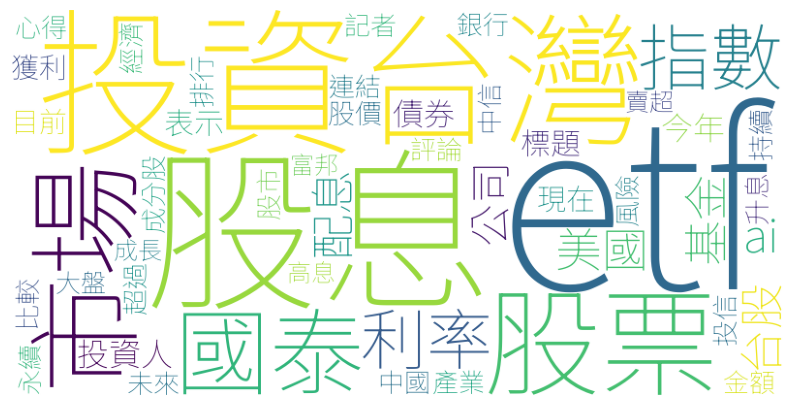

In [40]:
wordcloud = WordCloud(background_color = 'white', width = 800, height = 400,font_path=font_path, max_words = 50)
wordcloud.generate_from_frequencies(freq_dict)

# 設定圖的字體大小
plt.rcParams['font.size'] = 14

# 設定圖的中文字體 (無法顯示的話可以試試‘Microsoft JhengHei’字體)
# 也可參考：https://pyecontech.com/2020/03/27/python_matplotlib_chinese/


# 設定文字雲中文字體路徑

plt.figure(figsize = (10,7))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

## 主題模型
我不了解台灣債權最近在討論什麼，所以我先用主題模型看

In [98]:
topic_df=MetaData.copy()
# 設定斷詞 function
def getToken(row):
    seg_list = jieba.cut(row, cut_all=False)
    seg_list = [
        w for w in seg_list if w not in stopWords and len(w) > 1
    ]  # 篩選掉停用字與字元數大於1的詞彙
    return seg_list

topic_df["words"] = topic_df["artContent"].apply(getToken)
topic_df.head()

,system_id,artUrl,artTitle,artDate,artContent,words
0,1,https://www.ptt.cc/bbs/Finance/M.1684317581.A....,[新聞]TDR未經主管機關核定金管會陷人民於罪,2023-05-17,未經主管機關核定金管會陷人民於罪恐觸偽造文書因證券交易法未將臺灣存託憑證明文入法主管機關亦未...,"[未經, 主管機關, 核定, 金管會, 恐觸, 偽造, 文書, 證券交易, 法未將, 臺灣,..."
1,2,https://www.ptt.cc/bbs/Finance/M.1685429102.A....,[新聞]SWAP大爆發彰銀今年有看頭,2023-05-30,彰化銀行受惠台美利差擴大換匯交易獲利大爆發彰銀總經理周朝崇日在法說會中指出第一季收益逾億元年...,"[彰化, 銀行, 受惠, 台美, 利差, 擴大, 換匯, 交易, 獲利, 爆發, 彰銀, 總..."
2,3,https://www.ptt.cc/bbs/Finance/M.1685616807.A....,[新聞]永豐銀董座曹為實專訪／永豐銀做強做大,2023-06-01,新聞標題永豐銀董座曹為實專訪永豐銀做強做大三面向進擊新聞網址經濟日報記者楊筱筠台北報導永豐銀...,"[新聞標題, 永豐, 董座, 曹為實, 專訪, 永豐, 銀做強, 大三, 面向, 進擊, 新..."
3,4,https://www.ptt.cc/bbs/Finance/M.1687613871.A....,[請益]銀行往來資產的保險是怎麼計算的？,2023-06-24,台新富裕會員所有與本行往來之資產總額包含臺外幣存款基金結構型商品信託保險費之總金額不包含與往...,"[台新, 富裕, 會員, 所有, 本行, 往來, 資產, 總額, 包含, 外幣存款, 基金,..."
4,5,https://www.ptt.cc/bbs/Finance/M.1692747049.A....,[新聞]金管會曾示警壽險業閃過三大雷區,2023-08-23,新聞來源聯合新聞網金管會曾示警壽險業閃過三大雷區經濟日報記者廖珮君楊筱筠台北報導保險局副局長...,"[新聞來源, 聯合, 新聞網, 金管會, 示警, 壽險業, 閃過, 三大, 雷區, 經濟日報..."


In [99]:
docs = topic_df['words'].to_list()
docs[0]

['未經',
 '主管機關',
 '核定',
 '金管會',
 '恐觸',
 '偽造',
 '文書',
 '證券交易',
 '法未將',
 '臺灣',
 '憑證',
 '明文',
 '入法',
 '主管機關',
 '證券交易',
 '法第條',
 '項後段',
 '所定經',
 '主管機關',
 '核定',
 '有價證券',
 '臺灣',
 '憑證',
 '核定',
 '證券交易',
 '有價證券',
 '導致',
 '臺灣',
 '憑證',
 '爭議',
 '不斷',
 '爭議',
 '懸而未決',
 '情形',
 '司法',
 '實務',
 '已有',
 '多起',
 '當事人',
 '涉及',
 '炒作',
 '臺灣',
 '憑證',
 '判刑',
 '案件',
 '有林',
 '英鴻因',
 '涉及',
 '年間',
 '炒作',
 '東亞',
 '科遭',
 '判刑',
 '年月定',
 '鄒官羽',
 '劉旭章',
 '涉及',
 '年間',
 '炒作',
 '傳媒',
 '判刑',
 '文智因',
 '涉及',
 '年間',
 '炒作',
 '聯環',
 '判刑',
 '年月定',
 '文智',
 '涉及',
 '年間',
 '炒作',
 '明輝',
 '判刑',
 '目前',
 '法院',
 '二審',
 '審理',
 '尚未',
 '本件',
 '爭議',
 '源自',
 '證券交易',
 '法第條',
 '第項',
 '規定',
 '本法',
 '所稱',
 '有價證券',
 '政府',
 '債券',
 '公司股票',
 '公司債券',
 '及經',
 '主管機關',
 '核定',
 '有價證券',
 '金管會',
 '年月日',
 '金管證',
 '發字',
 '第號',
 '臺灣',
 '憑證',
 '財政部',
 '年月日',
 '財證',
 '二字',
 '第號',
 '公告',
 '核定',
 '具有',
 '投資',
 '性質',
 '有價證券',
 '臺北',
 '地院',
 '審鍾案',
 '法官',
 '臺灣',
 '憑證',
 '是否',
 '證券交易',
 '法第條',
 '有價證券',
 '主管機關',
 '何種',
 '方式',
 '核定',
 '臺灣',
 '憑證',
 '發函',
 '詢問',
 '金管會',
 '金

In [100]:
dictionary = Dictionary(docs)
# Filter out words that occur less than 5 documents, or more than 99% of the documents.
dictionary.filter_extremes(no_below=5, no_above=0.99)
print(dictionary)

Dictionary<7458 unique tokens: ['一下', '一直', '一種', '不斷', '不符']...>


In [101]:
for idx, (k, v) in enumerate(dictionary.token2id.items()):
    print(f"{k}: {v}")
    if idx > 10:
        break

一下: 0
一直: 1
一種: 2
不斷: 3
不符: 4
主管機關: 5
也就是說: 6
事情: 7
交易: 8
人員: 9
人權: 10
何種: 11


將斷詞結果建構語料庫(corpus)之後，利用語料庫把每篇文章數字化。<br>
每個詞彙都被賦予一個 ID 及頻率(word_id，word_frequency)。<br>

舉例來說：<br>
第一篇文章數字化結果為：corpus[600]:[(2, 2), (6, 1), (20, 2), .... ]，element 為文章中每個詞彙的 id 和頻率。<br>
代表：'世界'出現2次、'之戰'出現一次...以此類推

In [102]:
dictionary.doc2bow(topic_df['words'].iloc[600])[:10]

[(8, 1),
 (14, 1),
 (39, 8),
 (43, 2),
 (62, 4),
 (64, 1),
 (65, 2),
 (90, 1),
 (101, 1),
 (112, 3)]

In [103]:
corpus = [dictionary.doc2bow(doc) for doc in docs]

訓練 topic model

+ 參數說明：
    + corpus = 文檔語料庫
    + id2word = 詞彙字典
    + num_topics = 生成幾個主題數
    + random_state = 固定亂數值，每次的模型結果會一樣
    + iteration = 每個文章訓練的次數，可以設定高一點讓模型收斂
    + passes(epoch) = 整個 corpus 訓練模型的次數
    + alpha = 文章主題分佈
    + eta = 主題字分佈

模型參數沒有一個絕對的答案，同學們應該**使用相同的資料**，嘗試做參數上的調整，進而比較出較佳的模型結果。

In [104]:
ldamodel = LdaModel(
    corpus=corpus, 
    id2word=dictionary, # 字典
    num_topics=10, # 生成幾個主題數
    random_state=2024, # 亂數
)

In [105]:
ldamodel.print_topics()

[(0,
  '0.013*"利率" + 0.009*"投資" + 0.008*"股息" + 0.007*"現在" + 0.006*"風險" + 0.006*"比較" + 0.005*"美債" + 0.005*"債券" + 0.005*"定存" + 0.005*"真的"'),
 (1,
  '0.010*"市場" + 0.009*"中國" + 0.008*"指數" + 0.008*"投資" + 0.008*"風險" + 0.007*"資金" + 0.007*"美國" + 0.007*"經濟" + 0.006*"降息" + 0.006*"台灣"'),
 (2,
  '0.010*"投資" + 0.009*"億元" + 0.006*"公司" + 0.006*"中國" + 0.006*"股票" + 0.006*"美國" + 0.005*"成長" + 0.005*"產業" + 0.005*"台灣" + 0.005*"證券"'),
 (3,
  '0.014*"基金" + 0.013*"投資人" + 0.010*"股息" + 0.010*"配息" + 0.009*"投資" + 0.009*"投信" + 0.008*"市場" + 0.006*"淨值" + 0.006*"高息" + 0.006*"金管會"'),
 (4,
  '0.015*"納入" + 0.014*"剔除" + 0.009*"台灣" + 0.008*"成分股" + 0.008*"台股" + 0.008*"股息" + 0.008*"股價" + 0.008*"指數" + 0.007*"投資" + 0.007*"高息"'),
 (5,
  '0.018*"股息" + 0.008*"投資" + 0.008*"配息" + 0.007*"利率" + 0.007*"股票" + 0.006*"市場" + 0.006*"台灣" + 0.005*"現在" + 0.005*"股價" + 0.005*"目前"'),
 (6,
  '0.026*"債券" + 0.020*"降息" + 0.016*"利率" + 0.016*"美國" + 0.011*"投資" + 0.007*"美債" + 0.006*"公債" + 0.006*"預期" + 0.005*"現在" + 0.005*"經濟"'),
 (7,
  '0.008*"投資" + 0.0

In [106]:
ldamodel.get_document_topics(corpus[0])

[(2, 0.12267376), (3, 0.15831777), (7, 0.7156848)]

**4.3 查看 LDA 模型指標**
+ **Pointwise Mutual Information (PMI)** : <br>
自然語言處理中，想要探討兩個字之間是否存在某種關係。<br>
例如：某些字會一起出現，可能帶有某些訊息，因此這個可以用 PMI 來計算，數字越大越好。
+ **perplexity** :<br>
perplexity 也是評估的指標之一，廣泛用於語言模型的評估，意思為複雜度，因此數字要越小越好。

In [107]:
import time
import numpy as np
import pyLDAvis
import pyLDAvis.gensim_models

In [108]:
perplexity = ldamodel.log_perplexity(corpus)
np.exp2(-perplexity)

222.65032901552502

In [109]:
# npmi
NPMI_model_lda = CoherenceModel(model=ldamodel, texts=docs, coherence='c_npmi')
NPMI_lda = NPMI_model_lda.get_coherence()
print('這個主題的 PMI score: ', NPMI_lda)

這個主題的 PMI score:  0.006499765299685984


In [110]:
t0 = time.time()

topic_num_list = np.arange(2, 10)
result = {"topic_num":[], "perplexity":[], "pmi":[]}
model_set = dict()


for topic_num in topic_num_list:
    # perplexity
    model = LdaModel(
        corpus = corpus,
        num_topics = topic_num ,
        id2word=dictionary,
        random_state = 1500,
        passes=5 # 訓練次數
        )
    
    loss = model.log_perplexity(corpus)
    pmi = CoherenceModel(model=model, texts=docs, coherence='c_npmi').get_coherence()
    perplexity = np.exp(-1. * loss)
    
    # model_set[f'k_{topic_num}'] = model
    
    result['topic_num'].append(topic_num)
    result['perplexity'].append(perplexity)
    result['pmi'].append(pmi)
    
print(f"花費時間: {time.time() - t0} sec")

### 花費時間: 68.63594698905945 sec

花費時間: 65.55978107452393 sec


In [111]:
result = pd.DataFrame(result)
result

,topic_num,perplexity,pmi
0,2,2166.980285,-0.004826
1,3,2007.316904,0.033578
2,4,1900.919089,0.029815
3,5,1754.103609,0.032208
4,6,1693.278036,0.036982
5,7,1708.203734,0.004783
6,8,1700.943269,-0.007885
7,9,1707.095792,0.010104


<Axes: xlabel='topic_num'>

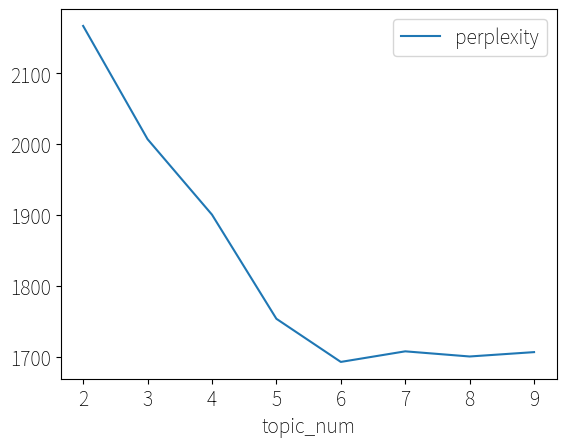

In [112]:
result.plot.line(x='topic_num', y='perplexity')

<Axes: xlabel='topic_num'>

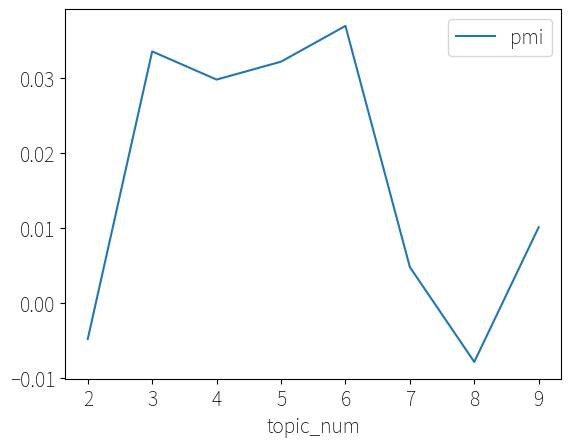

In [113]:
result.plot.line(x='topic_num', y='pmi')

In [131]:
best_model = LdaModel(
    corpus = corpus,
    num_topics = 4,
    id2word=dictionary,
    random_state = 1500,
    passes = 15 # 訓練次數
    )

In [132]:
pyLDAvis.enable_notebook()
p = pyLDAvis.gensim_models.prepare(best_model, corpus, dictionary)
p

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.162050 -0.148442       1        1  43.330610
2      0.063371  0.132309       2        1  27.479802
1      0.123324  0.045113       3        1  18.076708
3     -0.348745 -0.028981       4        1  11.112879, topic_info=     Term         Freq        Total Category  logprob  loglift
806    國泰  1475.000000  1475.000000  Default  30.0000  30.0000
2059   買超   905.000000   905.000000  Default  29.0000  29.0000
526    基金  1629.000000  1629.000000  Default  28.0000  28.0000
1621   中信   884.000000   884.000000  Default  27.0000  27.0000
2363   排行   711.000000   711.000000  Default  26.0000  26.0000
...   ...          ...          ...      ...      ...      ...
2531   統一   244.644557   535.522783   Topic4  -5.1051   1.4136
1541   高息   268.097908  1408.601825   Topic4  -5.0136   0.5381
2171   群益   233.288784   637.226791   Topic4  -5.1527   1.1922
249    以下   222.486603   448.055875   Topic4  -5.2001   1.4970
568    中國   223.136490  1385.700161   Topic4  -5.1972   0.3709

[334 rows x 6 columns], token_table=      Topic      Freq Term
term                      
0         1  0.809756   一下
0         2  0.148488   一下
0         3  0.041577   一下
1204      1  0.905646   一些
1204      2  0.040900   一些
...     ...       ...  ...
231       3  0.209879   風險
1541      2  0.714183   高息
1541      3  0.095130   高息
1541      4  0.190260   高息
2963      2  0.984046  高瑜君

[619 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 3, 2, 4])

主題一：利率、債券、美國、降息、中國、投資、股市、經濟等詞彙，暗示了可能在討論全球經濟狀況、利率政策、債券市場等相關議題。這可能涉及到對利率變動對金融市場和投資的影響、國際經濟形勢的分析、風險評估等內容。

主題二：股息、台股、指數、高息、台灣、納入、成分股、剔除、股價、成長等詞彙，暗示了可能在討論台灣股市相關議題，包括股息政策、股市指數動態、股票表現等內容。這可能是對台灣股市的分析和評論，包括個別股票和整體市場的走勢。

主題三：基金、金管會、投信、公司、申購、淨值、投資人、公告、配息等詞彙，暗示了可能在討論投資基金相關的話題，包括基金公司、基金產品、投資策略等內容。這可能是關於投資基金市場的新聞、公告和相關資訊。

主題四：國泰、買超、排行、賣超、中信、大美債、永豐、漲停、美債、金額等詞彙，暗示了可能在討論與金融投資、交易行為相關的話題。這可能是關於投資機構、金融產品、交易行為等方面的討論和資訊分享。

情緒分析

In [133]:
# 讀取情緒字典
liwc_dict = pd.read_csv("../dict/liwc/LIWC_CH.csv")
liwc_dict = liwc_dict.rename(columns={'name': 'word', "class": 'sentiments'})
liwc_dict.head()

,word,sentiments
0,):,affect
1,3q,affect
2,:(,affect
3,:),affect
4,<3,affect


In [134]:
word_df

,system_id,artUrl,artTitle,artDate,artContent,sentence,word
0,1,https://www.ptt.cc/bbs/Finance/M.1684317581.A....,[新聞]TDR未經主管機關核定金管會陷人民於罪,2023-05-17,tdr未經主管機關核定 金管會陷人民於罪恐觸「偽造文書」https://bit.ly/3be...,tdr未經主管機關核定 金管會陷人民於罪恐觸偽造文書 但仍存有許多模糊空間有在交易tdr多少...,tdr
1,1,https://www.ptt.cc/bbs/Finance/M.1684317581.A....,[新聞]TDR未經主管機關核定金管會陷人民於罪,2023-05-17,tdr未經主管機關核定 金管會陷人民於罪恐觸「偽造文書」https://bit.ly/3be...,理應也將之視為有價證券的一種但這模糊不清的定義又不知道又要害多少人去坐牢了google 一下...,未經
2,1,https://www.ptt.cc/bbs/Finance/M.1684317581.A....,[新聞]TDR未經主管機關核定金管會陷人民於罪,2023-05-17,tdr未經主管機關核定 金管會陷人民於罪恐觸「偽造文書」https://bit.ly/3be...,這部分台灣的法規貌似一直跟不上明明法界都在罵這事情,主管機關
3,1,https://www.ptt.cc/bbs/Finance/M.1684317581.A....,[新聞]TDR未經主管機關核定金管會陷人民於罪,2023-05-17,tdr未經主管機關核定 金管會陷人民於罪恐觸「偽造文書」https://bit.ly/3be...,不過上頭還是不為所動,核定
6,2,https://www.ptt.cc/bbs/Finance/M.1685429102.A....,[新聞]SWAP大爆發彰銀今年有看頭,2023-05-30,彰化銀行受惠台美利差擴大，swap（換匯交易）獲利大爆發。彰銀總經理周朝崇29日在法說會中指...,彰化銀行受惠台美利差擴大,偽造
...,...,...,...,...,...,...,...
87369,2699,https://www.ptt.cc/bbs/Stock/M.1715338980.A.AB...,[情報]113/05/10八大公股銀行買賣超排行,2024-05-10,1. 標題：113/05/10 八大公股銀行買賣超排行。2. 來源：玩股網。3. 網址：ht...,買超金額排行 賣超金額排行台積電長榮陽明光寶科中租ky長榮航賣超漲停顆燈,義工
87370,2699,https://www.ptt.cc/bbs/Stock/M.1715338980.A.AB...,[情報]113/05/10八大公股銀行買賣超排行,2024-05-10,1. 標題：113/05/10 八大公股銀行買賣超排行。2. 來源：玩股網。3. 網址：ht...,今日上市櫃共有漲停支跌停,債券
87371,2699,https://www.ptt.cc/bbs/Stock/M.1715338980.A.AB...,[情報]113/05/10八大公股銀行買賣超排行,2024-05-10,1. 標題：113/05/10 八大公股銀行買賣超排行。2. 來源：玩股網。3. 網址：ht...,美債etf買國泰年美債正,打算
87372,2699,https://www.ptt.cc/bbs/Stock/M.1715338980.A.AB...,[情報]113/05/10八大公股銀行買賣超排行,2024-05-10,1. 標題：113/05/10 八大公股銀行買賣超排行。2. 來源：玩股網。3. 網址：ht...,若有發現問題,資本


In [136]:
ptt_liwc_df = pd.merge(word_df[["artDate", "artTitle", "artContent", "word"]], liwc_dict, how="left")
ptt_liwc_df

,artDate,artTitle,artContent,word,sentiments
0,2023-05-17,[新聞]TDR未經主管機關核定金管會陷人民於罪,tdr未經主管機關核定 金管會陷人民於罪恐觸「偽造文書」https://bit.ly/3be...,tdr,NaN
1,2023-05-17,[新聞]TDR未經主管機關核定金管會陷人民於罪,tdr未經主管機關核定 金管會陷人民於罪恐觸「偽造文書」https://bit.ly/3be...,未經,NaN
2,2023-05-17,[新聞]TDR未經主管機關核定金管會陷人民於罪,tdr未經主管機關核定 金管會陷人民於罪恐觸「偽造文書」https://bit.ly/3be...,主管機關,NaN
3,2023-05-17,[新聞]TDR未經主管機關核定金管會陷人民於罪,tdr未經主管機關核定 金管會陷人民於罪恐觸「偽造文書」https://bit.ly/3be...,核定,NaN
4,2023-05-30,[新聞]SWAP大爆發彰銀今年有看頭,彰化銀行受惠台美利差擴大，swap（換匯交易）獲利大爆發。彰銀總經理周朝崇29日在法說會中指...,偽造,affect
...,...,...,...,...,...
87653,2024-05-10,[情報]113/05/10八大公股銀行買賣超排行,1. 標題：113/05/10 八大公股銀行買賣超排行。2. 來源：玩股網。3. 網址：ht...,義工,NaN
87654,2024-05-10,[情報]113/05/10八大公股銀行買賣超排行,1. 標題：113/05/10 八大公股銀行買賣超排行。2. 來源：玩股網。3. 網址：ht...,債券,NaN
87655,2024-05-10,[情報]113/05/10八大公股銀行買賣超排行,1. 標題：113/05/10 八大公股銀行買賣超排行。2. 來源：玩股網。3. 網址：ht...,打算,NaN
87656,2024-05-10,[情報]113/05/10八大公股銀行買賣超排行,1. 標題：113/05/10 八大公股銀行買賣超排行。2. 來源：玩股網。3. 網址：ht...,資本,NaN


In [137]:
def sentiment_generate(input):
    sentiment_count = pd.DataFrame(
        input.groupby(["artDate", "sentiments"]).size()
        ).reset_index()

    mask = (sentiment_count['sentiments'] == "positive") | (sentiment_count['sentiments'] == "negative") 
    sentiment_count = sentiment_count.loc[mask]

    sentiment_count = sentiment_count.rename(columns={0: "size"})
    sentiment_count = sentiment_count.sort_values(["artDate"])
    sentiment_count = sentiment_count.assign(
        ratio=sentiment_count.groupby("artDate")["size"].transform(lambda n: n / n.sum())
    )
    ptt_sentiment_value = (
        sentiment_count.pivot_table(
            index="artDate", columns="sentiments", values="size", fill_value=0
        )
        .reset_index()
        .rename_axis(None, axis=1)
    )
    ptt_sentiment_value["sentiment_value"] = (
        ptt_sentiment_value["positive"]
        - ptt_sentiment_value["negative"]
    )
    return ptt_sentiment_value
    # fig, ax = plt.subplots()

    # rolling_days = 10
    # ax.plot(ptt_sentiment_value["artDate"], ptt_sentiment_value["sentiment_value"].rolling(rolling_days).mean())
    # ax.set_xlabel("artDate")
    # ax.set_ylabel("sentiment value")
    # fig.autofmt_xdate()
    # plt.title(f"{title}球團情緒分數")

Text(0.5, 0, 'artDate')

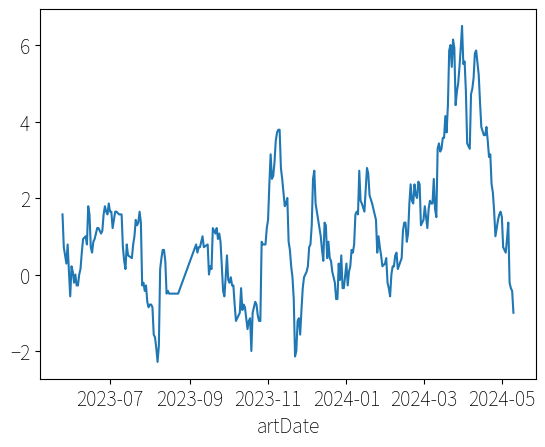

In [140]:
pos = sentiment_generate(ptt_liwc_df)
fig, ax = plt.subplots()
rolling_days = 14
ax.plot(pos["artDate"], pos['sentiment_value'].rolling(rolling_days).mean())
plt.xlabel("artDate")